<a href="https://colab.research.google.com/github/AritraStark/Deeplense_GSOC_2022/blob/main/Deeplense_test_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Specific Test II. Lens Finding**

**Task:** Build a model for classifying the images into lenses using PyTorch or Keras. Pick the most appropriate approach and discuss your strategy.

**Dataset:** https://drive.google.com/file/d/1F-X2gCEqXvX9Rj_mIu_KiNaO3o8o_0E3/view?usp=sharing

**Dataset Description:** A data set comprising images with and without strong lenses.

**Evaluation Metrics:** ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve) 

Downloading the data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!tar --extract --file '/content/gdrive/MyDrive/lenses.tgz' 
print('Extraction done.')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Extraction done.


Setting up the imports:

In [12]:
pip install -U tensorflow-addons


     |████████████████████████████████| 1.1 MB 28.7 MB/s 


In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
import tensorflow_addons as tfa

Extracting the data from the lense images:


In [5]:
X_data = []
Y_data = []

#substructure data
sub = os.listdir('/content/lenses/sub')
for i in sub:
    img = cv2.imread('/content/lenses/sub/' + i)
    img = img / 255.0
    X_data.append(img)
    Y_data.append(1)

#no-substructure data
no_sub = os.listdir('/content/lenses/no_sub')
for i in no_sub:
    img = cv2.imread('/content/lenses/no_sub/' + i)
    img = img / 255.0
    X_data.append(img)
    Y_data.append(0)

Shuffling to introduce randomness in the data:



In [6]:
data = list(zip(X_data, Y_data))
np.random.shuffle(data)
X_data, Y_data = zip(*data)

#delete to free redundant space
del data

X_data = np.array(X_data)
Y_data = np.array(Y_data)

Visualising the images belonging to the two classes:


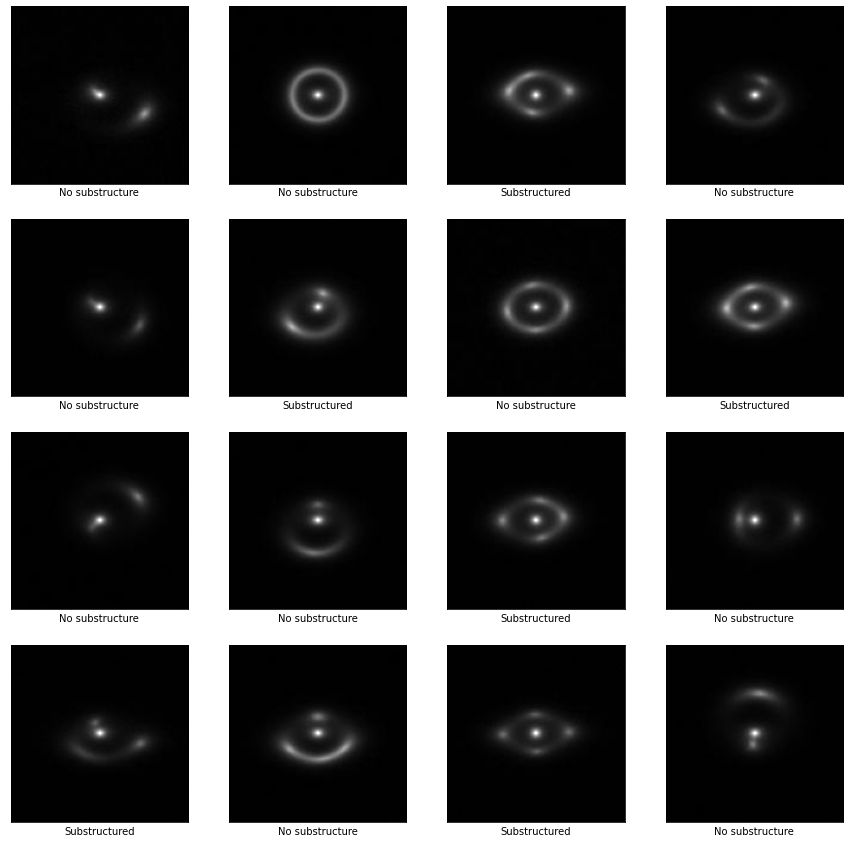

In [7]:
classes = ["Substructured", "No substructure"]
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    num = np.random.randint(0, len(X_data))
    plt.imshow(X_data[num])
    plt.xlabel(classes[Y_data[num]])
plt.show()

Splitting the data into training and validation:

In [8]:
X_train , X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42, shuffle=True)
X_data.shape, Y_data.shape

((10000, 150, 150, 3), (10000,))

Deleting large variables to free up memory:


In [9]:
del X_data, Y_data
del img, no_sub, sub

In [14]:
num_classes = 2
input_shape = (150, 150, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 20
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [17]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


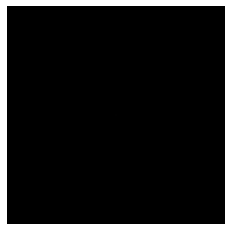

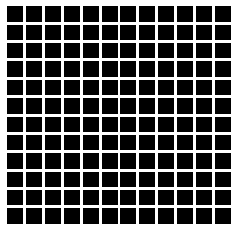

In [19]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
def create_vit_classifier():
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/20
225/225 [==============================] - 26s 73ms/step - loss: 1.7652 - accuracy: 0.5053 - top-5-accuracy: 1.0000 - val_loss: 0.7143 - val_accuracy: 0.4938 - val_top-5-accuracy: 1.0000
Epoch 2/20
225/225 [==============================] - 15s 65ms/step - loss: 0.7128 - accuracy: 0.5203 - top-5-accuracy: 1.0000 - val_loss: 0.6914 - val_accuracy: 0.5063 - val_top-5-accuracy: 1.0000
Epoch 3/20
225/225 [==============================] - 15s 66ms/step - loss: 0.7048 - accuracy: 0.5075 - top-5-accuracy: 1.0000 - val_loss: 0.6997 - val_accuracy: 0.5063 - val_top-5-accuracy: 1.0000
Epoch 4/20
225/225 [==============================] - 15s 66ms/step - loss: 0.7017 - accuracy: 0.4994 - top-5-accuracy: 1.0000 - val_loss: 0.6922 - val_accuracy: 0.5063 - val_top-5-accuracy: 1.0000
Epoch 5/20
225/225 [==============================] - 14s 64ms/step - loss: 0.6963 - accuracy: 0.5161 - top-5-accuracy: 1.0000 - val_loss: 0.6885 - val_accuracy: 0.4950 - val_top-5-accuracy: 1.0000
Epoch 6/20

Predict on the validation data and load the best saved weight:



In [ ]:
model.load_weights('weights.08-0.08.h5')
predictions = model.predict(X_test)
temp_predictions = []
for i in range(len(predictions)):
    k = np.argmax(predictions[i])
    temp_predictions.append(k)

temp_predictions = np.array(temp_predictions)


Plotting the ROC AUC curve:



In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, temp_predictions)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()